# GTSF phase: biomass prediction

In this notebook, we are forecasting the weights by finding the closest blender model

### Look at the volumes created with blender

Load blender data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

import glob
import os
import boto3
import tempfile
from sqlalchemy import create_engine, MetaData, Table, select, and_, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import norm
import tqdm
import pickle
from itertools import combinations

from PIL import Image, ImageDraw
from multiprocessing import Pool, Manager
import copy
import uuid
from sklearn.preprocessing import StandardScaler





<h1> Get world keypoint coordinates from GTSF data </h1>

In [25]:
aws_credentials = json.load(open(os.environ["AWS_CREDENTIALS"]))
s3_client = boto3.client('s3', aws_access_key_id=aws_credentials["aws_access_key_id"],
                         aws_secret_access_key=aws_credentials["aws_secret_access_key"],
                         region_name="eu-west-1")


sql_credentials = json.load(open(os.environ["SQL_CREDENTIALS"]))
sql_engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                           sql_credentials["host"], sql_credentials["port"],
                           sql_credentials["database"]))

Session = sessionmaker(bind=sql_engine)
session = Session()

Base = automap_base()
Base.prepare(sql_engine, reflect=True)
Enclosure = Base.classes.enclosures
Calibration = Base.classes.calibrations
GtsfDataCollection = Base.classes.gtsf_data_collections
StereoFramePair = Base.classes.stereo_frame_pairs


<h1> Utility functions for world keypoint normalization </h1>

In [26]:
def generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

In [27]:
def euclidean_distance(p1, p2):
    if type(p1) == list:
        p1 = np.array(p1)
    if type(p2) == list:
        p2 = np.array(p2)
    return np.linalg.norm(p1 - p2)


def normalize_world_keypoints(wkps):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['TAIL_NOTCH'] for bp in body_parts}
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp]) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['DORSAL_FIN'] - np.array([norm_wkps_intermediate['DORSAL_FIN'][0], 0, 0])
    R = generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    # perform reflecton if necessary
    if norm_wkps['PECTORAL_FIN'][1] > 0:
        norm_wkps = {bp: np.array([
            norm_wkps[bp][0],
            -norm_wkps[bp][1],
            norm_wkps[bp][2]
        ]) for bp in body_parts}
    
    return norm_wkps
    



<h1> Utility Method: World Keypoint Calculation </h1>

In [28]:
# DEFINE OPTICAL PROPERTIES

# all distance are in meters
FOCAL_LENGTH = 0.00843663
BASELINE = 0.128096
PIXEL_SIZE_M = 3.45 * 1e-6
FOCAL_LENGTH_PIXEL = FOCAL_LENGTH / PIXEL_SIZE_M
IMAGE_SENSOR_WIDTH = 0.01412
IMAGE_SENSOR_HEIGHT = 0.01035
PIXEL_COUNT_WIDTH = 4096
PIXEL_COUNT_HEIGHT = 3000

def convert_to_world_point(x, y, d):
    """ from pixel coordinates to world coordinates """
    
    image_center_x = PIXEL_COUNT_WIDTH / 2.0  
    image_center_y = PIXEL_COUNT_HEIGHT / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y

    sensor_x = px_x * (IMAGE_SENSOR_WIDTH / PIXEL_COUNT_WIDTH)
    sensor_z = px_z * (IMAGE_SENSOR_HEIGHT / PIXEL_COUNT_HEIGHT)

    # d = depth_map[y, x]
    world_y = d
    world_x = (world_y * sensor_x) / FOCAL_LENGTH
    world_z = (world_y * sensor_z) / FOCAL_LENGTH
    return np.array([world_x, world_y, world_z])

def depth_from_disp(disp):
    """ calculate the depth of the point based on the disparity value """
    depth = FOCAL_LENGTH_PIXEL*BASELINE / np.array(disp)
    return depth

def disp_from_depth(depth):
    disp = FOCAL_LENGTH_PIXEL * BASELINE / depth
    return disp


<h1> Generate accuracy metrics on GTSF data </h1>

In [29]:
def generate_lateral_keypoints(left_image, right_image, left_keypoints, right_keypoints, world_keypoints, 
                               bp_1='UPPER_LIP', bp_2='TAIL_NOTCH', left_window_size=100, 
                               min_breadth=0.04, max_breadth=0.2):
    left_extrap_kp = (0.5 * left_keypoints[bp_1] + 0.5 * left_keypoints[bp_2]).astype('int64')
    bp_1_depth = world_keypoints[bp_1][1]
    bp_2_depth = world_keypoints[bp_2][1]

    # need to determine lower and upper bounds here in a data driven fashion from GTSF data
    # hardcoded values used here
    extrap_kp_max_depth = (bp_1_depth + bp_2_depth) / 2.0 - min_breadth / 2.0
    extrap_kp_min_depth = (bp_1_depth + bp_2_depth) / 2.0 - max_breadth / 2.0

    # Compute the feature descriptor for the extrapolated keypoint in the left image
    extrap_kp_min_disp = disp_from_depth(extrap_kp_max_depth)
    extrap_kp_max_disp = disp_from_depth(extrap_kp_min_depth)
    
    left_box = left_image[left_extrap_kp[1]-left_window_size//2:left_extrap_kp[1]+left_window_size//2, 
                          left_extrap_kp[0]-left_window_size//2:left_extrap_kp[0]+left_window_size//2]
    right_box = right_image[left_extrap_kp[1]-left_window_size//2:left_extrap_kp[1]+left_window_size//2,
                            left_extrap_kp[0]-int(extrap_kp_max_disp)-left_window_size//2:left_extrap_kp[0]-int(extrap_kp_min_disp)+left_window_size//2]

    
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(left_box,None)
    kp2, des2 = orb.detectAndCompute(right_box,None)
    
    # get top five matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)[:5]
    
    # get world coordinates of lateral keypoints
    lateral_wkps = []
    for match in matches[:5]:
        
        lateral_left_coordinates = np.array(kp1[match.queryIdx].pt).astype(int)
        lateral_left_coordinates[0] += left_extrap_kp[0]-left_window_size//2
        lateral_left_coordinates[1] += left_extrap_kp[1]-left_window_size//2
        
        lateral_right_coordinates = np.array(kp2[match.trainIdx].pt).astype(int)
        lateral_right_coordinates[0] += left_extrap_kp[0]-int(extrap_kp_max_disp)-left_window_size//2
        lateral_right_coordinates[1] += left_extrap_kp[1]-left_window_size//2
        
        disp = abs(lateral_left_coordinates[0] - lateral_right_coordinates[0])
        depth = depth_from_disp(disp)
        lateral_wkp = convert_to_world_point(lateral_left_coordinates[0], lateral_left_coordinates[1], depth)
        lateral_wkps.append(lateral_wkp)
        
    return np.array(lateral_wkps)


def process_stereo_frame_pair(sfp, world_keypoints_dict):
    if sfp['gtsf_fish_identifier'] == '190321010002':
        return
    ground_truth_metadata = json.loads(sfp['ground_truth_metadata'])
    if ground_truth_metadata['data'].get('species') != 'salmon':
        return
        
    # download left and right images
    random_hash = uuid.uuid4().hex
    left_image_f = 'left_image_{}.jpg'.format(random_hash)
    right_image_f = 'right_image_{}.jpg'.format(random_hash)

    left_image_s3_key, right_image_s3_key, s3_bucket = sfp['left_image_s3_key'], sfp['right_image_s3_key'], sfp['image_s3_bucket']
    s3_client.download_file(s3_bucket, left_image_s3_key, left_image_f)
    s3_client.download_file(s3_bucket, right_image_s3_key, right_image_f)
    
    left_image = cv2.imread(left_image_f)
    right_image = cv2.imread(right_image_f)
    
    # get left, right, and world keypoints
    left_keypoints = json.loads(sfp['left_image_keypoint_coordinates'])
    right_keypoints = json.loads(sfp['right_image_keypoint_coordinates'])
    world_keypoints = json.loads(sfp['world_keypoint_coordinates'])
    
    # convert coordinates from lists to numpy arrays
    left_keypoints = {k: np.array(v) for k, v in left_keypoints.items()}
    right_keypoints = {k: np.array(v) for k, v in right_keypoints.items()}
    world_keypoints = {k: np.array(v) for k, v in world_keypoints.items()}
     
    lateral_wkps = generate_lateral_keypoints(left_image, right_image, left_keypoints, right_keypoints, world_keypoints)
    world_keypoints['BODY'] = lateral_wkps
    world_keypoints_dict[sfp['id']] = world_keypoints
    if len(world_keypoints_dict) % 10 == 0:
        print(len(world_keypoints_dict))
    
    os.remove(left_image_f)
    os.remove(right_image_f)
    



In [ ]:
manager = Manager()
world_keypoints_dict = manager.dict()

session.rollback()
sfps_all = session.query(StereoFramePair).all()
args = []
for row in sfps_all:
    row_copy = copy.copy(row)
    sfp = row_copy.__dict__
    del sfp['_sa_instance_state']
    args.append((sfp, world_keypoints_dict))

pool = Pool(processes=20)
pool.starmap(process_stereo_frame_pair, args)

<h1> Train linear model with PCA + interaction features </h1>

In [30]:
sfps_all = session.query(StereoFramePair).all()
df = pd.DataFrame()

body_parts = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
])

session.rollback()
for idx, row in enumerate(sfps_all):
    if idx % 10 == 0:
        print(idx)
        
    # get fish_id and ground truth metadata
    if row.gtsf_fish_identifier == '190321010002':
        continue
    gtsf_data_collection_id = row.gtsf_data_collection_id
    gtsf_data_collection = session.query(GtsfDataCollection).get(gtsf_data_collection_id)
    ground_truth_metadata = json.loads(gtsf_data_collection.ground_truth_metadata)
    if ground_truth_metadata['data'].get('species') != 'salmon':
        continue
    
#     world_keypoints = world_keypoints_dict[row.id]
    wkps = json.loads(row.world_keypoint_coordinates)
#     body_wkp = world_keypoints['BODY'].mean(axis=0)
#     wkps = copy.copy(world_keypoints)
#     wkps['BODY'] = body_wkp
    df_row = {'0': idx}
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            d = euclidean_distance(wkps[body_parts[i]], wkps[body_parts[j]])
            df_row['{0}-{1}'.format(i, j)] = d
    
    
    weight = ground_truth_metadata['data']['weight']
    length = ground_truth_metadata['data']['length']
    width = ground_truth_metadata['data']['width']
    breadth = ground_truth_metadata['data']['breath']
    df_row['weight'] = weight
    df_row['length'] = length
    df_row['width'] = width
    df_row['breadth'] = breadth
    df_row['kfactor'] = 1e5 * weight / length**3
    df_row['date'] = row.date
    df = df.append(df_row, ignore_index=True)
            
    
df_cache = df.copy()
df = df.dropna()


0
10
20
30


Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL SYSCALL error: EOF detected



40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700


In [31]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    


In [32]:
# define all features


pairwise_distance_columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(list(range(len(body_parts))), 2))]
interaction_columns = []
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        col1 = pairwise_distance_columns[i]
        col2 = pairwise_distance_columns[j]
        interaction_column = '{},{}'.format(col1, col2)
        df[interaction_column] = df[col1] * df[col2]
        interaction_columns.append(interaction_column)

In [65]:
mask = generate_train_mask(df, train_frac=0.8)
mask = mask & (df.date.astype(str) < '2019-05-02')


columns = pairwise_distance_columns + interaction_columns

X_train = df.loc[mask, columns].values
y_train = df.loc[mask, 'weight'].values
X_test = df.loc[~mask, columns].values
y_test = df.loc[~mask, 'weight'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)

pca = PCA(n_components=min(X_train_normalized.shape[0], X_train_normalized.shape[1]))
pca.fit(X_train_normalized)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
idx = np.where(explained_variance_ratio > 0.99999)[0][0]
print(idx)

pca = PCA(n_components=idx+1)
pca.fit(X_train_normalized)
X_train_transformed = pca.transform(X_train_normalized)
X_test_normalized = scaler.transform(X_test)
X_test_transformed = pca.transform(X_test_normalized)

reg = LinearRegression().fit(X_train_transformed, y_train)
print(reg.score(X_test_transformed, y_test))

y_pred = reg.predict(pca.transform(scaler.transform(df[columns].values)))
df['prediction'] = y_pred
df['error'] = df.prediction - df.weight
df['error_pct'] = df.error / df.weight
df['abs_error_pct'] = df.error_pct.abs()

model = {
    'mean': scaler.mean_,
    'std': scaler.scale_,
    'PCA_components': pca.components_,
    'reg_coef': reg.coef_,
    'reg_intercept': reg.intercept_,
    'body_parts': body_parts   
}



51
0.933686793186252


In [44]:
mask = generate_train_mask(df, train_frac=0.8)
columns = pairwise_distance_columns + interaction_columns

X_test = df.loc[~mask, columns].values
y_test = df.loc[~mask, 'weight'].values

X_test_normalized = (X_test - output['mean']) / output['std']
X_test_transformed = np.dot(X_test_normalized, output['PCA_components'].T)

y_pred = np.dot(X_test_transformed, reg.coef_) + reg.intercept_


NameError: name 'output' is not defined

In [77]:
pickle.dump(model, open('model.pkl', 'wb'))

In [78]:
def coord2biomass(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - output['mean']) / output['std']
    X_transformed = np.dot(X_normalized, output['PCA_components'].T)
    prediction = np.dot(X_transformed, reg.coef_) + reg.intercept_
    return prediction

In [54]:
mean = model['mean']
std = model['std']
PCA_components = model['PCA_components']
reg_coef = model['reg_coef']
reg_intercept = model['reg_intercept']
body_parts = model['body_parts']

# calculate pairwise distances for production coord
# based on the exact ordering reflected in the body_parts
# variable above

pairwise_distances = []
for i in range(len(body_parts)-1):
    for j in range(i+1, len(body_parts)):
        dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
        pairwise_distances.append(dist)

interaction_values = []
for i in range(len(pairwise_distances)):
    for j in range(i, len(pairwise_distances)):
        dist1 = pairwise_distances[i]
        dist2 = pairwise_distances[j]
        interaction_values.append(dist1 * dist2)

X = np.array(pairwise_distances + interaction_values)

X_normalized = (X - model['mean']) / model['std']
X_transformed = np.dot(X_normalized, model['PCA_components'].T)
prediction = np.dot(X_transformed, reg.coef_) + reg.intercept_
print(prediction)

NameError: name 'world_keypoints' is not defined

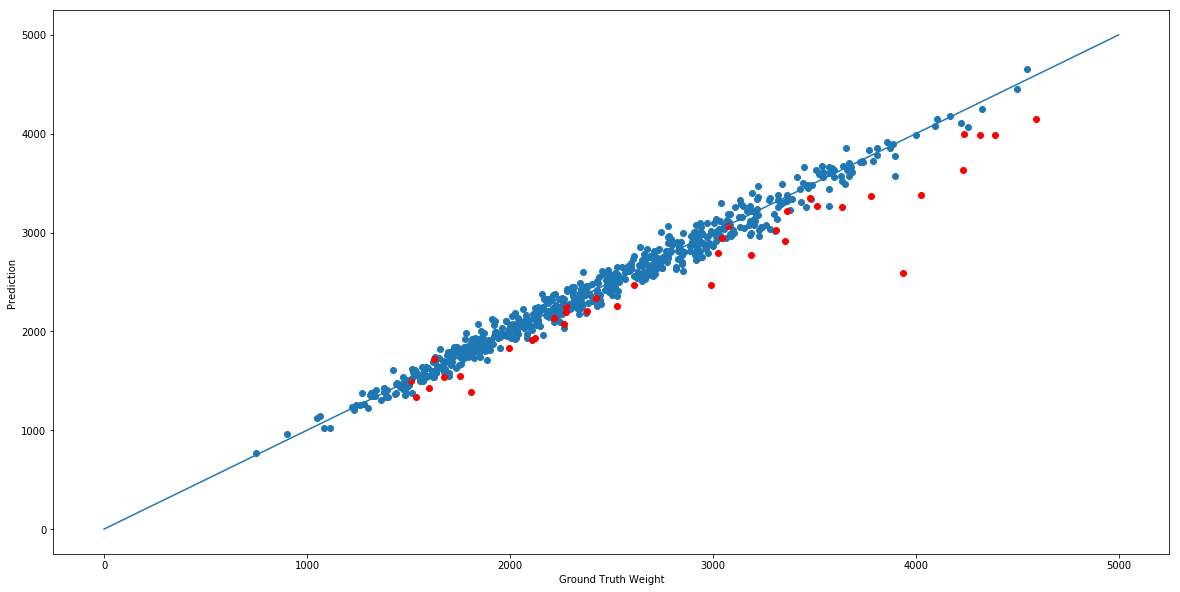

In [66]:
%matplotlib inline
plt.figure(figsize=(20, 10))
date_mask = df.date.astype(str) != '2019-05-02'
plt.scatter(df[date_mask]['weight'], df[date_mask]['prediction'])
plt.scatter(df[~date_mask]['weight'], df[~date_mask]['prediction'], color='r')
plt.xlabel('Ground Truth Weight')
plt.ylabel('Prediction')
plt.plot(range(5000), range(5000))


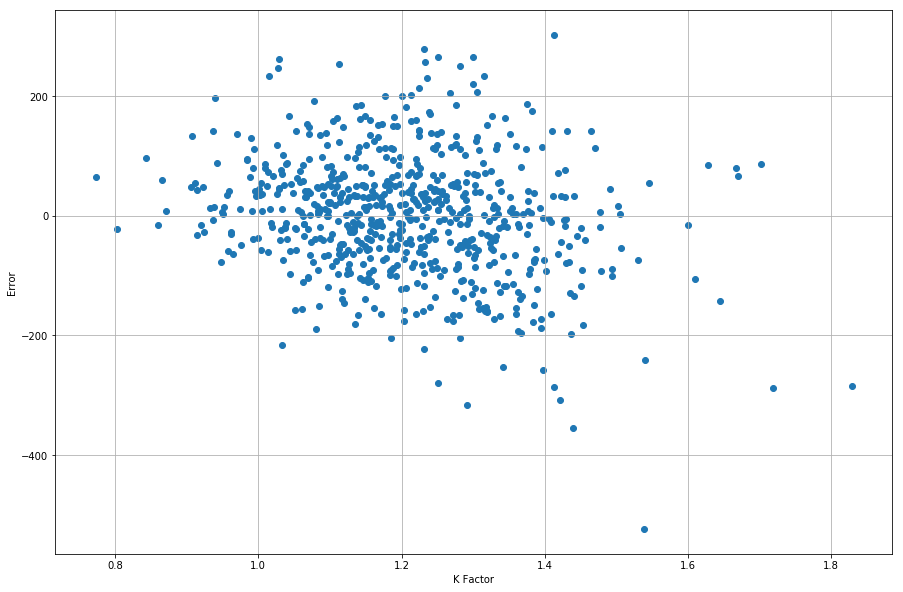

In [21]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.xlabel('K Factor')
plt.ylabel('Error')
plt.scatter(df['kfactor'], df['error'])


In [83]:
N = 1000

# perform N-fold cross validation
abs_err_pcts = []
error_stds = []
for i in range(N):
    if i % 10 == 0:
        print(i)
    mask = generate_train_mask(df, train_frac=0.8)

    columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(list(range(8)), 2))]
    X_train = df.loc[mask, columns].values
    y_train = df.loc[mask, 'weight'].values
    X_test = df.loc[~mask, columns].values
    y_test = df.loc[~mask, 'weight'].values

    pca = PCA(n_components=min(X_train.shape[0], X_train.shape[1]))
    pca.fit(X_train)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    idx = np.where(explained_variance_ratio > 0.99999)[0][0]

    pca = PCA(n_components=idx+1)
    pca.fit(X_train)
    X_train_modified = pca.transform(X_train)
    X_test_modified = pca.transform(X_test)
    reg = LinearRegression().fit(X_train_modified, y_train)


    y_pred = reg.predict(pca.transform(df[columns].values))
    df['prediction'] = y_pred
    df['error'] = df.prediction - df.weight
    df['error_pct'] = df.error / df.weight
    df['abs_error_pct'] = df.error_pct.abs()
    error_std = df.loc[~mask, 'error_pct'].std()
    error_stds.append(error_std)

    
    avg_biomass_err = df.loc[~mask, 'prediction'].mean() - df.loc[~mask, 'weight'].mean()
    abs_err_pct = abs(avg_biomass_err) / df.loc[~mask, 'weight'].mean()
    abs_err_pcts.append(abs_err_pct)
    
    



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


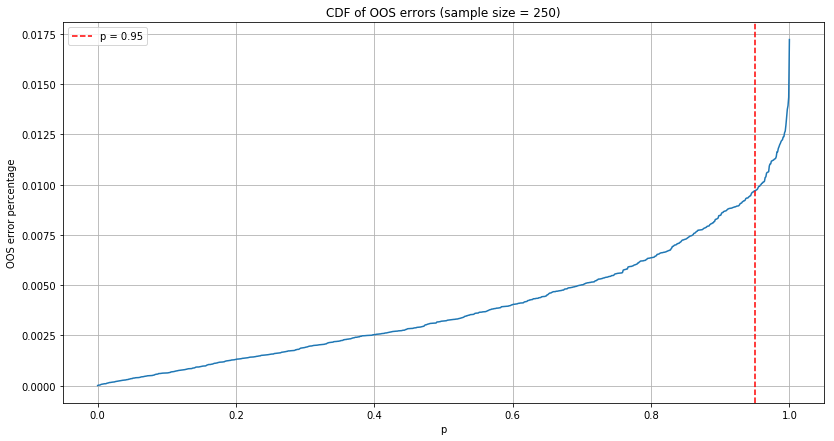

In [84]:
data_sorted = sorted(list(abs_err_pcts))
p = 1.0 * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
fig = plt.figure(figsize=(30, 7))
ax1 = fig.add_subplot(121)
ax1.plot(p, data_sorted)
ax1.set_xlabel('p')
ax1.set_ylabel('OOS error percentage')
plt.axvline(x=0.95, linestyle='--', color='red', label='p = 0.95')
plt.title('CDF of OOS errors (sample size = 250)')
plt.legend()
plt.grid()



<h1> Prod implementation test </h1>

In [60]:
import numpy as np
from sqlalchemy import create_engine, MetaData, Table, exc

def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)**0.5


def convert_to_world_point(x, y, d, parameters):
    """ from pixel coordinates to world coordinates """
    # get relevant parameters
    pixel_count_height = parameters["pixelCountHeight"]
    pixel_count_width = parameters["pixelCountWidth"]
    sensor_width = parameters["imageSensorWidth"]
    sensor_height = parameters["imageSensorHeight"]
    focal_length = parameters["focalLength"]

    image_center_x = pixel_count_height / 2.0
    image_center_y = pixel_count_width / 2.0
    px_x = x - image_center_x
    px_z = image_center_y - y

    sensor_x = px_x * (sensor_height / pixel_count_height)
    sensor_z = px_z * (sensor_width / pixel_count_width)

    # now move to world coordinates
    world_y = d
    world_x = (world_y * sensor_x) / focal_length
    world_z = (world_y * sensor_z) / focal_length
    return np.array([world_x, world_y, world_z])


def depth_from_disp(disp, parameters):
    """ calculate the depth of the point based on the disparity value """
    focal_length_pixel = parameters["focalLengthPixel"]

    baseline = parameters["baseline"]
    depth = focal_length_pixel * baseline / np.array(disp)
    return depth


def pixel2world(left_crop, right_crop, parameters):
    """2D pixel coordinates to 3D world coordinates"""

    # first create a dic with crop keypoints
    image_coordinates = {"leftCrop": {},
                         "rightCrop": {}}
    for keypoint in left_crop:
        name = keypoint["keypointType"]
        image_coordinates["leftCrop"][name] = [keypoint["xFrame"], keypoint["yFrame"]]
    for keypoint in right_crop:
        name = keypoint["keypointType"]
        image_coordinates["rightCrop"][name] = [keypoint["xFrame"], keypoint["yFrame"]]

    # then loop through the right crop keypoints and calculate the world coordinates
    world_coordinates = {}
    for keypoint in left_crop:
        name = keypoint["keypointType"]
        disparity = image_coordinates["leftCrop"][name][0] - image_coordinates["rightCrop"][name][0]
        depth = depth_from_disp(disparity, parameters)
        world_point = convert_to_world_point(image_coordinates["leftCrop"][name][1],
                                             image_coordinates["leftCrop"][name][0],
                                             depth,
                                             parameters)
        world_coordinates[name] = world_point
    return world_coordinates


def coord2biomass(world_keypoints, model):
    """from coordinates to biomass"""

    mean = model['mean']
    std= model['std']
    PCA_components = model['PCA_components']
    reg_coef = model['reg_coef']
    reg_intercept = model['reg_intercept']
    body_parts = model['body_parts']
    print(body_parts)

    # calculate pairwise distances for production coord
    # based on the exact ordering reflected in the body_parts
    # variable above

    pairwise_distances = []
    for i in range(len(body_parts)-1):
        for j in range(i+1, len(body_parts)):
            dist = euclidean_distance(world_keypoints[body_parts[i]], world_keypoints[body_parts[j]])
            pairwise_distances.append(dist)
            print(body_parts[i], body_parts[j], dist)
    print(pairwise_distances)
    
    interaction_values = []
    for i in range(len(pairwise_distances)):
        for j in range(i, len(pairwise_distances)):
            dist1 = pairwise_distances[i]
            dist2 = pairwise_distances[j]
            interaction_values.append(dist1 * dist2)

    X = np.array(pairwise_distances + interaction_values)

    X_normalized = (X - model['mean']) / model['std']
    X_transformed = np.dot(X_normalized, model['PCA_components'].T)
    prediction = np.dot(X_transformed, reg_coef) + reg_intercept
    return prediction


In [61]:
jsondata = json.load(open('sample_message.json'))
model = pickle.load(open('model.pkl', 'rb'))

In [62]:
# annotation_id = jsondata["annotationId"]
parameters = jsondata["cameraParameters"]
right_crop = jsondata["rightCrop"]
left_crop = jsondata["leftCrop"]
site_id = jsondata["siteId"]
pen_id = jsondata["penId"]



# pixel coordinates to world coordinates
coordinates = pixel2world(left_crop, right_crop, parameters)
biomass = coord2biomass(coordinates, model)

['ADIPOSE_FIN', 'ANAL_FIN', 'DORSAL_FIN', 'EYE', 'PECTORAL_FIN', 'PELVIC_FIN', 'TAIL_NOTCH', 'UPPER_LIP']
ADIPOSE_FIN ANAL_FIN 0.10979052330078688
ADIPOSE_FIN DORSAL_FIN 0.25040123011466614
ADIPOSE_FIN EYE 0.460257047721238
ADIPOSE_FIN PECTORAL_FIN 0.403941861836645
ADIPOSE_FIN PELVIC_FIN 0.22292467862408744
ADIPOSE_FIN TAIL_NOTCH 0.1803508261332636
ADIPOSE_FIN UPPER_LIP 0.5406247186491531
ANAL_FIN DORSAL_FIN 0.25105514855275296
ANAL_FIN EYE 0.4214909931419654
ANAL_FIN PECTORAL_FIN 0.3526216784434354
ANAL_FIN PELVIC_FIN 0.14864894461577838
ANAL_FIN TAIL_NOTCH 0.21881128437415098
ANAL_FIN UPPER_LIP 0.5009647459559271
DORSAL_FIN EYE 0.22765411193221327
DORSAL_FIN PECTORAL_FIN 0.20000465028858505
DORSAL_FIN PELVIC_FIN 0.17097403660527977
DORSAL_FIN TAIL_NOTCH 0.4270271499603032
DORSAL_FIN UPPER_LIP 0.31605965681834336
EYE PECTORAL_FIN 0.08660163146408507
EYE PELVIC_FIN 0.28027176314663754
EYE TAIL_NOTCH 0.6270594317927781
EYE UPPER_LIP 0.1303323292821168
PECTORAL_FIN PELVIC_FIN 0.20683839

In [63]:
biomass

4044.7342242058967

In [55]:
euclidean_distance(coordinates['TAIL_NOTCH'], coordinates['UPPER_LIP'])

0.6970914261337866